<a href="https://colab.research.google.com/github/anushkayadav/Denoising_cifar10/blob/master/Denoise_DnCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import math


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# convert data to a normalized torch.FloatTensor
transform = transforms.ToTensor()
# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)



num_workers = 0
noise_factor=0.1
batch_size = 32

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)


# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
use_cuda = torch.cuda.is_available()

print(use_cuda)

True


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [ ]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
# convert images to numpy for display

noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)
images = images.numpy() 
noisy_imgs=noisy_imgs.numpy()
def showOrigDec(orig, noise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        imshow(orig[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display noisy
        ax = plt.subplot(2, n, i +1 + n)
        imshow(noise[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.figtext(0.5,0.95, "ORIGINAL IMAGES", ha="center", va="top", fontsize=14, color="r")
    plt.figtext(0.5,0.5, "NOISY IMAGES", ha="center", va="top", fontsize=14, color="r")
    plt.subplots_adjust(hspace = 0.3 )
        
    plt.show()

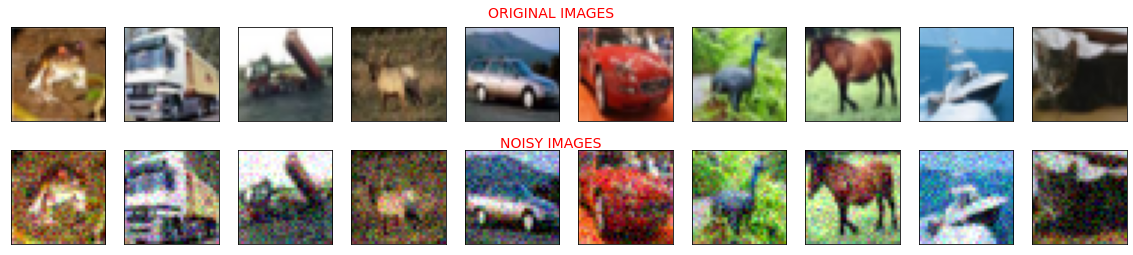

In [ ]:
showOrigDec(images,noisy_imgs)

# Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class DnCNN(nn.Module):
    def __init__(self, num_layers=17, num_features=64):
        super(DnCNN, self).__init__()
        layers = [nn.Sequential(nn.Conv2d(3, num_features, kernel_size=3, stride=1, padding=1),
                                nn.ReLU(inplace=True))]
        for i in range(num_layers - 2):
            layers.append(nn.Sequential(nn.Conv2d(num_features, num_features, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(num_features),
                                        nn.ReLU(inplace=True)))
        layers.append(nn.Conv2d(num_features, 3, kernel_size=3, padding=1))
        self.layers = nn.Sequential(*layers)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, inputs):
        y = inputs
        residual = self.layers(y)
        return y - residual

# initialize the NN
model = DnCNN()
model.cuda()
print(model)

DnCNN(
  (layers): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [ ]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
print(type(train_loader))
for data in train_loader:
    images, target = data
    print(target)
    print(images.shape)
    break

<class 'torch.utils.data.dataloader.DataLoader'>
tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6,
        2, 6, 3, 5, 4, 0, 0, 9])
torch.Size([32, 3, 32, 32])


In [ ]:
# number of epochs to train the model
n_epochs = 40


for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        
        ## add random noise to the input images
        noisy_imgs = images + noise_factor * torch.randn(*images.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
                
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        ## forward pass: compute predicted outputs by passing *noisy* images to the model
        outputs = model(noisy_imgs.cuda())
        # calculate the loss
        # the "target" is still the original, not-noisy images
        loss = criterion(outputs, images.cuda())
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.343218
Epoch: 2 	Training Loss: 0.099999
Epoch: 3 	Training Loss: 0.072915
Epoch: 4 	Training Loss: 0.063571
Epoch: 5 	Training Loss: 0.067289
Epoch: 6 	Training Loss: 0.055220
Epoch: 7 	Training Loss: 0.052529
Epoch: 8 	Training Loss: 0.051614
Epoch: 9 	Training Loss: 0.048445
Epoch: 10 	Training Loss: 0.047340
Epoch: 11 	Training Loss: 0.046588
Epoch: 12 	Training Loss: 0.046038
Epoch: 13 	Training Loss: 0.045356
Epoch: 14 	Training Loss: 0.044983
Epoch: 15 	Training Loss: 0.044515
Epoch: 16 	Training Loss: 0.049190
Epoch: 17 	Training Loss: 0.044731
Epoch: 18 	Training Loss: 0.043902
Epoch: 19 	Training Loss: 0.043747
Epoch: 20 	Training Loss: 0.043879
Epoch: 21 	Training Loss: 0.043564
Epoch: 22 	Training Loss: 0.043244
Epoch: 23 	Training Loss: 0.057483
Epoch: 24 	Training Loss: 0.049283
Epoch: 25 	Training Loss: 0.045857
Epoch: 26 	Training Loss: 0.044779
Epoch: 27 	Training Loss: 0.044101
Epoch: 28 	Training Loss: 0.043668
Epoch: 29 	Training Loss: 0.0

In [ ]:
torch.save(model,"denoise_DnCNN.pt")

C:\Users\sjasu\anaconda3\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type DnCNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
model.load_state_dict(torch.load('dcnn.pt'))

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# add noise to the test images
noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

# get sample outputs
output = model(noisy_imgs.cuda())



# output is resized into a batch of iages
output = output.view(batch_size, 3, 32, 32)
# use detach when it's an output that requires_grad
output = output.detach().cpu()



## **Image Comparison**

In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# add noise to the test images
noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

def showOrigNoiseOut(orig, noise, denoise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 6))

    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i+1)
        imshow(orig[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display noisy image
        ax = plt.subplot(3, n, i +1 + n)
        imshow(noise[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display denoised image
        ax = plt.subplot(3, n, i +1 + n + n)
        imshow(denoise[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.figtext(0.5,0.95, "ORIGINAL IMAGES", ha="center", va="top", fontsize=14, color="b")
    plt.figtext(0.5,0.65, "NOISY IMAGES", ha="center", va="top", fontsize=14, color="b")
    plt.figtext(0.5,0.35, " DENOISED RECONSTRUCTED IMAGES", ha="center", va="top", fontsize=14, color="b")
    plt.subplots_adjust(hspace = 0.5 )
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


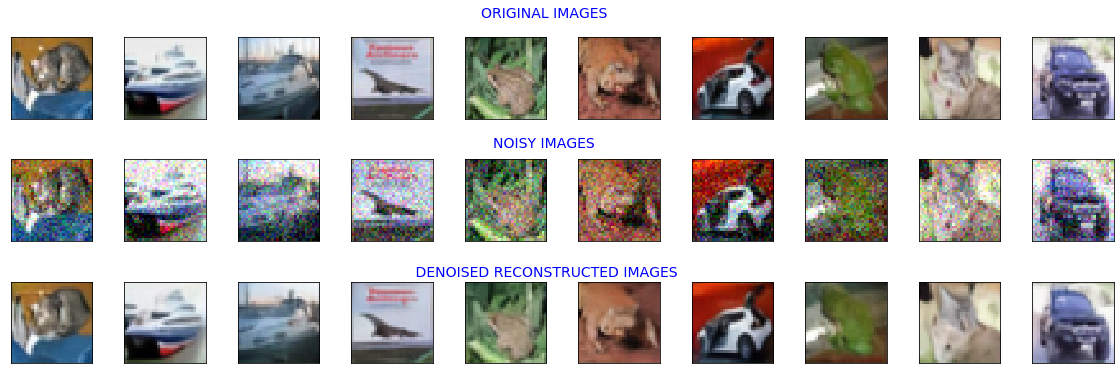

In [ ]:
showOrigNoiseOut(images, noisy_imgs, output)

In [ ]:
from skimage import metrics

avg_psnr=0
avg_ssim=0
test_size=0
for data in test_loader:
    images= data[0]
    noisy_imgs = images + noise_factor * torch.randn(*images.shape)
    noisy_imgs = np.clip(noisy_imgs, 0., 1.)
    output = model(noisy_imgs.cuda())
    output = output.view(len(images), 3, 32, 32)
    output = output.detach().cpu()
    batch_avg_psnr=0
    batch_avg_ssim=0
    for i in range(len(images)):
        org=np.transpose(images[i], (1, 2, 0)).numpy()
        denoise=np.transpose(output[i], (1, 2, 0)).numpy()
        batch_avg_psnr+=metrics.peak_signal_noise_ratio(org,denoise)
        batch_avg_ssim+=metrics.structural_similarity(org,denoise,multichannel=True)
    avg_psnr+=batch_avg_psnr
    avg_ssim+=batch_avg_ssim
    test_size+=len(images)

print("On Test data of {} examples:\nAverage PSNR:{:.3f} \nAverage SSIM: {:.3f}".format(test_size,avg_psnr/test_size,avg_ssim/test_size))

On Test data of 10000 examples:
Average PSNR:28.992 
Average SSIM: 0.947
